# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 29, 11:59PM

### Name: [Daksh Bhuva]


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [7]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import keras
import numpy as np
import tensorflow.keras

### If you can not load keras dataset, un-comment these two lines.
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [8]:
def to_one_hot(y, num_class=10):
  onehot_encoded = np.zeros((y.size, num_class))
  onehot_encoded[np.arange(y.size), y.reshape((1, y.size))] = 1
  return onehot_encoded
  pass

x_train, x_test = x_train.astype('float32') / 255, x_test.astype('float32') / 255

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [9]:
rand_indices = np.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Build a CNN and tune its hyper-parameters (50 points)

- Build a convolutional neural network model using the below structure:

- It should have a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="/content/network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

## Original Model:

In [ ]:
# Build the model

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(32, 32, 3)))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4), activation = 'relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 256)               5

In [ ]:
# Define model optimizer and loss function

from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 0.0001) , metrics=['acc'])

In [ ]:
# Train the model and store model parameters/loss values

history_orig = model.fit(x_tr, y_tr, batch_size=40, epochs=100, validation_data=(x_val, y_val))
model.save('original_model.h5')

Epoch 1/100
1000/1000 [==============================] - 20s 10ms/step - loss: 1.7683 - acc: 0.3729 - val_loss: 1.5341 - val_acc: 0.4584
Epoch 2/100
1000/1000 [==============================] - 9s 9ms/step - loss: 1.4608 - acc: 0.4847 - val_loss: 1.3600 - val_acc: 0.5209
Epoch 3/100
1000/1000 [==============================] - 10s 10ms/step - loss: 1.3324 - acc: 0.5334 - val_loss: 1.3018 - val_acc: 0.5297
Epoch 4/100
1000/1000 [==============================] - 10s 10ms/step - loss: 1.2465 - acc: 0.5688 - val_loss: 1.2122 - val_acc: 0.5703
Epoch 5/100
1000/1000 [==============================] - 10s 10ms/step - loss: 1.1808 - acc: 0.5912 - val_loss: 1.1587 - val_acc: 0.5915
Epoch 6/100
1000/1000 [==============================] - 11s 11ms/step - loss: 1.1248 - acc: 0.6108 - val_loss: 1.1258 - val_acc: 0.6009
Epoch 7/100
1000/1000 [==============================] - 10s 10ms/step - loss: 1.0793 - acc: 0.6252 - val_loss: 1.1044 - val_acc: 0.6097
Epoch 8/100
1000/1000 [====================

## 3. Plot the training and validation loss curve versus epochs. (5 points)

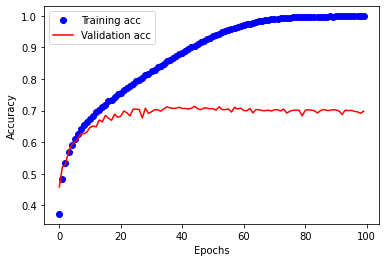

In [ ]:
# Plot the loss curve

import matplotlib.pyplot as plt
%matplotlib inline

acc = history_orig.history['acc']
val_acc = history_orig.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [ ]:
#<Compile your model again (using the same hyper-parameters you tuned above)>

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(32, 32, 3)))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4), activation = 'relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(10, activation='softmax'))

from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 0.0001) , metrics=['acc'])

In [ ]:
#<Train your model on the entire training set (50K samples)>

history_final = model.fit(x_train, y_train_vec, batch_size=40, epochs=100)
model.save('final_model.h5')

Epoch 1/100
1250/1250 [==============================] - 11s 8ms/step - loss: 1.7233 - acc: 0.3901
Epoch 2/100
1250/1250 [==============================] - 11s 8ms/step - loss: 1.4056 - acc: 0.5018
Epoch 3/100
1250/1250 [==============================] - 11s 8ms/step - loss: 1.2816 - acc: 0.5486
Epoch 4/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.1984 - acc: 0.5807
Epoch 5/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.1293 - acc: 0.6069
Epoch 6/100
1250/1250 [==============================] - 11s 9ms/step - loss: 1.0736 - acc: 0.6251
Epoch 7/100
1250/1250 [==============================] - 13s 11ms/step - loss: 1.0270 - acc: 0.6424
Epoch 8/100
1250/1250 [==============================] - 12s 10ms/step - loss: 0.9852 - acc: 0.6585
Epoch 9/100
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9502 - acc: 0.6713
Epoch 10/100
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9191 - acc: 0.6832
Epoch 1

## 5. Evaluate the model on the test set (5 points)

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [ ]:
# Evaluate your model performance (testing accuracy) on testing data.

from keras.models import load_model
model = load_model('original_model.h5')
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 2s 4ms/step - loss: 2.4996 - acc: 0.6904
loss = 2.499619960784912
accuracy = 0.6904000043869019


In [ ]:
# Evaluate your model performance (testing accuracy) on testing data.

from keras.models import load_model
model = load_model('final_model.h5')
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 2s 4ms/step - loss: 2.5541 - acc: 0.7035
loss = 2.5541446208953857
accuracy = 0.703499972820282


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

## Model 1 (BN + Data_Augmentation):

In [ ]:
# Build the model

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 64)       2

In [ ]:
# Using data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True)

In [ ]:
# Define model optimizer and loss function
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1E-3), metrics=['acc'])

In [ ]:
# Fits the model on batches with real-time data augmentation

history_augmt = model.fit(train_datagen.flow(x_tr, y_tr, batch_size=40), steps_per_epoch=x_tr.shape[0] // 40, epochs=150, validation_data=(x_val, y_val), validation_batch_size=x_val.shape[0] // 40)
model.save('data_augmt_model.h5')

Epoch 1/150
1000/1000 [==============================] - 48s 37ms/step - loss: 1.5709 - acc: 0.4343 - val_loss: 1.8509 - val_acc: 0.4142
Epoch 2/150
1000/1000 [==============================] - 39s 39ms/step - loss: 1.3131 - acc: 0.5324 - val_loss: 1.2476 - val_acc: 0.5543
Epoch 3/150
1000/1000 [==============================] - 37s 37ms/step - loss: 1.2169 - acc: 0.5646 - val_loss: 1.1623 - val_acc: 0.5920
Epoch 4/150
1000/1000 [==============================] - 37s 37ms/step - loss: 1.1501 - acc: 0.5927 - val_loss: 1.3540 - val_acc: 0.5460
Epoch 5/150
1000/1000 [==============================] - 37s 37ms/step - loss: 1.1054 - acc: 0.6079 - val_loss: 1.0723 - val_acc: 0.6408
Epoch 6/150
1000/1000 [==============================] - 37s 37ms/step - loss: 1.0624 - acc: 0.6260 - val_loss: 1.1799 - val_acc: 0.6115
Epoch 7/150
1000/1000 [==============================] - 37s 37ms/step - loss: 1.0343 - acc: 0.6365 - val_loss: 0.8989 - val_acc: 0.6852
Epoch 8/150
1000/1000 [==================

## Plot the training and validation loss curve versus epochs.

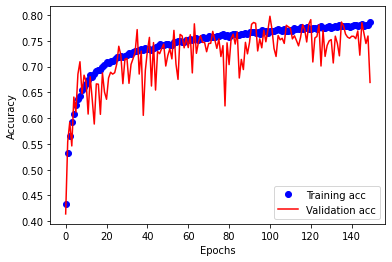

In [ ]:
# Plot the loss curve

import matplotlib.pyplot as plt
%matplotlib inline

acc = history_augmt.history['acc']
val_acc = history_augmt.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Train (again) and evaluate the model
- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [10]:
#<Compile your model again (using the same hyper-parameters you tuned above)>

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10, activation='softmax'))

from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 0.0001) , metrics=['acc'])

# using data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True)

In [12]:
# Train the model and store model parameters/loss values

history_final_augmt = model.fit(train_datagen.flow(x_train, y_train_vec, batch_size=40), steps_per_epoch=x_tr.shape[0] // 32, epochs=150)
model.save('final_data_augmt_model.h5')

Epoch 1/150
1250/1250 [==============================] - 38s 30ms/step - loss: 1.6466 - acc: 0.4034
Epoch 2/150
1250/1250 [==============================] - 37s 30ms/step - loss: 1.4427 - acc: 0.4816
Epoch 3/150
1250/1250 [==============================] - 37s 30ms/step - loss: 1.3547 - acc: 0.5174
Epoch 4/150
1250/1250 [==============================] - 37s 30ms/step - loss: 1.2874 - acc: 0.5434
Epoch 5/150
1250/1250 [==============================] - 37s 30ms/step - loss: 1.2400 - acc: 0.5596
Epoch 6/150
1250/1250 [==============================] - 37s 30ms/step - loss: 1.2068 - acc: 0.5718
Epoch 7/150
1250/1250 [==============================] - 38s 30ms/step - loss: 1.1824 - acc: 0.5831
Epoch 8/150
1250/1250 [==============================] - 38s 30ms/step - loss: 1.1539 - acc: 0.5899
Epoch 9/150
1250/1250 [==============================] - 38s 30ms/step - loss: 1.1277 - acc: 0.6019
Epoch 10/150
1250/1250 [==============================] - 38s 30ms/step - loss: 1.1102 - acc: 0.6067

## Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [ ]:
# Evaluate your model performance (testing accuracy) on testing data.

from keras.models import load_model
model = load_model('data_augmt_model.h5')
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 2s 5ms/step - loss: 1.1030 - acc: 0.6632
loss = 1.1030269861221313
accuracy = 0.6632000207901001


In [13]:
# Evaluate your model performance (testing accuracy) on testing data.

from keras.models import load_model
model = load_model('final_data_augmt_model.h5')
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 2s 5ms/step - loss: 0.6504 - acc: 0.7792
loss = 0.6504468321800232
accuracy = 0.77920001745224


## Model 2 (BN + Dropout):

In [ ]:
# Build the model

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 64)       2

In [ ]:
# Define model optimizer and loss function

from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1E-4), metrics=['acc'])

In [ ]:
# Train the model and store model parameters/loss values

history_bn_dropout = model.fit(x_tr, y_tr, batch_size=40, epochs=100, validation_data=(x_val, y_val))
model.save('bn_dropout_model.h5')

Epoch 1/100
1000/1000 [==============================] - 24s 13ms/step - loss: 1.7040 - acc: 0.3880 - val_loss: 1.3660 - val_acc: 0.5193
Epoch 2/100
1000/1000 [==============================] - 12s 12ms/step - loss: 1.3742 - acc: 0.5095 - val_loss: 1.1906 - val_acc: 0.5855
Epoch 3/100
1000/1000 [==============================] - 12s 12ms/step - loss: 1.2522 - acc: 0.5553 - val_loss: 1.1191 - val_acc: 0.6135
Epoch 4/100
1000/1000 [==============================] - 12s 12ms/step - loss: 1.1671 - acc: 0.5859 - val_loss: 1.0684 - val_acc: 0.6276
Epoch 5/100
1000/1000 [==============================] - 13s 13ms/step - loss: 1.1046 - acc: 0.6089 - val_loss: 1.0469 - val_acc: 0.6293
Epoch 6/100
1000/1000 [==============================] - 12s 12ms/step - loss: 1.0523 - acc: 0.6282 - val_loss: 1.0066 - val_acc: 0.6422
Epoch 7/100
1000/1000 [==============================] - 12s 12ms/step - loss: 1.0140 - acc: 0.6443 - val_loss: 0.9483 - val_acc: 0.6655
Epoch 8/100
1000/1000 [==================

## Plot the training and validation loss curve versus epochs.

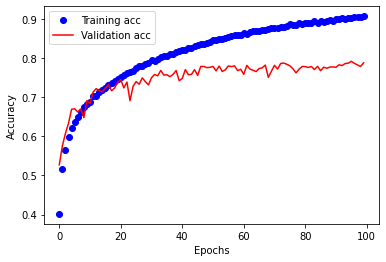

In [ ]:
# Plot the loss curve

import matplotlib.pyplot as plt
%matplotlib inline

acc = history_bn_dropout.history['acc']
val_acc = history_bn_dropout.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Train (again) and evaluate the model
- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [ ]:
#<Compile your model again (using the same hyper-parameters you tuned above)>

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (4, 4)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(10, activation='softmax'))

from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1E-4), metrics=['acc'])

In [ ]:
# Train the model and store model parameters/loss values

history_bn_dropout = model.fit(x_train, y_train_vec, batch_size=40, epochs=100)
model.save('final_bn_dropout_model.h5')

Epoch 1/100
1250/1250 [==============================] - 25s 11ms/step - loss: 1.6303 - acc: 0.4181
Epoch 2/100
1250/1250 [==============================] - 14s 11ms/step - loss: 1.2876 - acc: 0.5449
Epoch 3/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.1565 - acc: 0.5913
Epoch 4/100
1250/1250 [==============================] - 19s 15ms/step - loss: 1.0758 - acc: 0.6216
Epoch 5/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.0230 - acc: 0.6397
Epoch 6/100
1250/1250 [==============================] - 14s 11ms/step - loss: 0.9755 - acc: 0.6581
Epoch 7/100
1250/1250 [==============================] - 14s 11ms/step - loss: 0.9426 - acc: 0.6685
Epoch 8/100
1250/1250 [==============================] - 14s 11ms/step - loss: 0.9091 - acc: 0.6832
Epoch 9/100
1250/1250 [==============================] - 14s 11ms/step - loss: 0.8833 - acc: 0.6879
Epoch 10/100
1250/1250 [==============================] - 14s 11ms/step - loss: 0.8603 - acc: 0.6982

##  Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.


In [ ]:
# Evaluate your model performance (testing accuracy) on testing data.

from keras.models import load_model
model = load_model('bn_dropout_model.h5')
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 2s 5ms/step - loss: 0.6877 - acc: 0.7817
loss = 0.6877126097679138
accuracy = 0.7817000150680542


In [ ]:
# Evaluate your model performance (testing accuracy) on testing data.

from keras.models import load_model
model = load_model('final_bn_dropout_model.h5')
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 2s 5ms/step - loss: 0.6445 - acc: 0.7943
loss = 0.6444640159606934
accuracy = 0.7943000197410583


## Comparision and Analysis:

- ***Original CNN model:*** has a accuracy of **69.04 %** and after training the network on the entire training set has accuracy of **70.35 %**.
- ***Model 1 (BN + Data_Augmentation):*** has a accuracy of **66.32 %** and after training the network on the entire training set has accuracy of **77.92** %. 
- ***Model 2 (BN + Dropout):*** has a accuracy of **78.17 %** and after training the network on the entire training set has accuracy of **79.43 %**.

**~** Clearly ***Model 2*** achieves the best accuracy amongst the above models.

**~** Model 1 may achieve more accuracy if the model is trained for more epochs but it is not possible due to limited access to GPU in Google Colab 

